# Introduction
We go over the basic functionality of the code by initializing a detector and creating some time-ordered data. 

We start by importing the `ScanStrategy` and `Beam` classes from `beamconv`. We we will also need some functions from `healpy`.

In [1]:
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
from beamconv import Instrument
from beamconv import Beam
from beamconv import tools

For simplicity we will only use a single detector in this example. Detectors are represented by instances of the `Beam` class we just imported. A `Beam` instance contains detector properties such as pointing offsets, but also pointers to the harmonic modes of the actual beam.

First lets see what options we are allowed to set set for our `Beam` instance:

In [2]:
?Beam()

Let's create a detector without pointing offset (i.e. one that sits in the middle of the focal plane). For now we simply take a Gaussian beam. We can fully specify the beam with the `fwhm` (Full Width at Half Maximum) parameter. Here we pick `fwhm=40`, in units of arcmin.

In [3]:
beam_opts = dict(az=0, 
                 el=0,
                 polang=0,
                 fwhm=40,
                 btype='Gaussian', 
                 lmax=800,
                 mmax=2)
beam = Beam(**beam_opts)
print beam

name   : None 
btype  : Gaussian 
alive  : True 
FWHM   : 40 arcmin 
az     : 0 deg 
el     : 0 deg 
polang : 0.0 deg



In order to start simulating data we need to initialize a `ScanStrategy` instance that manages the simulated data-taking. `ScanStrategy` inherents from the `Instrument` class, so by initializing it we also initialize an `Instrument` instance. Let's see what both classes need as input:

In [4]:
?Instrument()

In [5]:
?ScanStrategy()

For simplicity we pick a preset location for the instrument (the south pole). For the scan strategy we mostly use the defaults but specify that we would like to simulate one hour of data at a 100 Hz sample rate.

In [6]:
instr_opts = dict(location='spole')
scan_opts = dict(duration=3600,
                 sample_rate=100)
scan_opts.update(instr_opts)

S = ScanStrategy(**scan_opts)

Lets add our beam to the detectors focal plane. Each `Instrument` instance has a `beams` attribute: a list of detector pairs, representing the focal plane. Because we only have a single detector, our detector will have a empty slot as detector partner.

In [7]:
S.add_to_focal_plane(beam)
print(S.beams)

[[<beamconv.detector.Beam object at 0x10af34a10>, None]]


We now specify the telescope's pointing (the boresight pointing). As an example, we simply use a preset scan strategy: a constant-elevation scanning pattern. To do so, we use the `constant_el_scan()` method of our `ScanStrategy` instance. Lets see what input we need to provide:

In [8]:
?S.constant_el_scan()

We leave the scan centre set to its default value (`ra0`, `dec0` = -10, -57.5, which is always visible from the south pole) and set the scanning speed and azimuthal width.

In [9]:
const_el_opts = dict(az_throw=50.,
                     scan_speed=10.,
                     dec0=-70.)                   

In [10]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
_, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=800, new=True, verbose=False) # uK

The actual scanning of the sky can be done by using the `scan_instrument_mpi` method of `ScanStrategy`. Broadly speaking, this function first calls the `init_spinmaps` function that performs the inverse spherical harmonic transforms needed for the beam convolution, then it calls the `constant_el_scan` function we mentioned above to populate the boresight pointing quaternions. Finally, it calls the `scan` function that combines boresight pointing, detector pointing and the beam-convolved maps to calculate the final time-ordered data. 

Note that `scan_instrument_mpi` will also work with more than one detector on the focal plane, possibly distributing the workload over available MPI ranks. 

Because we have only a single detector, we can separate the inverse spherical harmonic transforms and the scanning. To do so, we first call the `init_detpair` function. This will populate the beam-convolved `spinmaps` (and might take 1 - 10 sec). If we then call  `scan_instrument_mpi` with `reuse_spinmaps=True` it will use the precomputed `spinmaps`.

In [11]:
beam = S.beams[0][0]
S.init_detpair(alm, beam, beam_b=None, nside_spin=512, verbose=False)

In [12]:
S.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=True, interp=False, save_tod=True, **const_el_opts)
tod = S.data(S.chunks[0], beam=beam, data_type='tod')

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


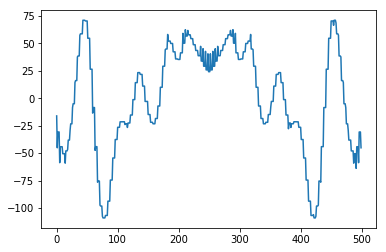

In [13]:
fig, ax = plt.subplots()
ax.plot(tod[:500])

We can rerun with the `interp` option set to True to use bi-linear interpolation while sampling the beam-convolved maps in order to make the data look smoother.

In [14]:
S.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=True, interp=True, save_tod=True, **const_el_opts)
tod_interp = S.data(S.chunks[0], beam=beam, data_type='tod')

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


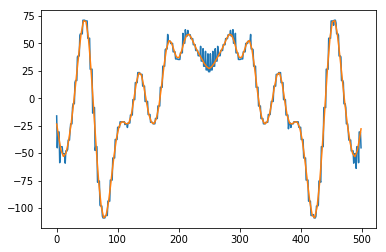

In [15]:
fig, ax = plt.subplots()
ax.plot(tod[:500])
ax.plot(tod_interp[:500])

# Temperature-to-Polarization leakage

With the basic structure of the code set, we take a look at a leading-order systematic.

We use precomputed harmonic modes for a detector coupled to a 380 mm 2-lens refracting telescope.

In [16]:
beam_opts = dict(az=0, 
                 el=0,
                 polang=0,
                 fwhm=40,
                 btype='Gaussian', 
                 lmax=800,
                 mmax=5,
                 po_file='../tests/test_data/example_blms/blm_hp_X1T1R1C8A_800_800.npy',)
beam = Beam(**beam_opts)

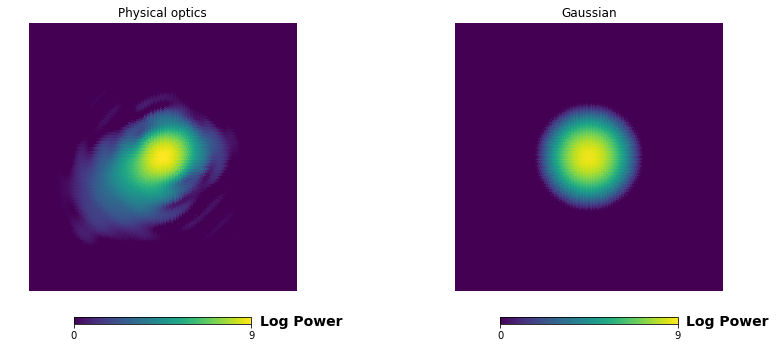

In [17]:
def blm2bmap(beam, nside=1024):
    blm = np.asarray(beam.blm).copy()[0]
    ell = np.arange(hp.Alm.getlmax(blm.size))
    q_ell = np.sqrt(4. * np.pi / (2 * ell + 1))
    blm = hp.almxfl(blm, 1 / q_ell)
    return hp.alm2map(blm, nside, verbose=False)

beam.btype='PO'
bmap_po = blm2bmap(beam)
del(beam.blm)
beam.btype='Gaussian'
bmap_ga = blm2bmap(beam)
del(beam.blm)

cart_opts = dict(rot=[0, 90, 0], lonra=[-3,3], latra=[-3,3], min=0, max=9, hold=True, unit='Log Power')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))
plt.axes(ax1)
hp.cartview(np.log(np.abs(bmap_po)), title="Physical optics", **cart_opts)
plt.axes(ax2)
hp.cartview(np.log(np.abs(bmap_ga)), title="Gaussian", **cart_opts)

In [18]:
S2 = ScanStrategy(**scan_opts)
S2.set_instr_rot(period=100, angles=np.linspace(0, 360, 10))
S2.add_to_focal_plane(beam)
beam2 = S2.beams[0][0]

In [19]:
S2.set_btypes('Gaussian')
alm = np.asarray(alm)
alm[1] *= 0
alm[2] *= 0

In [20]:
S2.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=False, interp=False, 
                       save_point=True, save_tod=True, nside_spin=512, **const_el_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


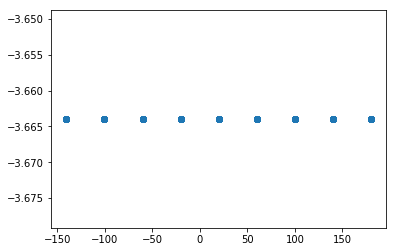

In [21]:
pix2 = S2.data(S2.chunks[0], beam=beam2, data_type='pix')
pa2 = S2.data(S2.chunks[0], beam=beam2, data_type='pa')
tod2 = S2.data(S2.chunks[0], beam=beam2, data_type='tod')

common_pix2 = np.bincount(pix2).argmax()
plt.scatter(pa2[pix2==common_pix2], tod2[pix2==common_pix2])

In [22]:
S2.set_btypes('PO')
S2.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=False, interp=False, 
                       save_point=True, save_tod=True, nside_spin=512, **const_el_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


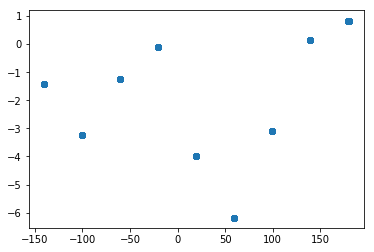

In [23]:
pix2 = S2.data(S2.chunks[0], beam=beam2, data_type='pix')
pa2 = S2.data(S2.chunks[0], beam=beam2, data_type='pa')
tod2 = S2.data(S2.chunks[0], beam=beam2, data_type='tod')

common_pix2 = np.bincount(pix2).argmax()
plt.scatter(pa2[pix2==common_pix2], tod2[pix2==common_pix2])